# Data cleaning - Filter definition

The objective of this notebook is to filter out the observations that we believe are not useful for our analysis of public transit travel pattern. For instances, unfrequent users, or smartcards with suspicious transactions are unlikely to have a enough relevant observations to infere home and work location. 

We will use a data-drive approach to define the best cut-off point to filter relevant users. For this approach, we will create a summary table. Each row will correspond to a unique ID, and for each ID, we will establish the following variables: 

1. Total number of transactions [Tr]
2. Time spam (Day of last transaction - Day of First transaction) [Ts]
3. Days of use (Number of days with at least one transaction)[Du]
4. Average transactions per day [Tr/Ts]
5. Average transactions per day of use [Tr/Du]

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np 
import pandas as pd 
import sys 
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
path = '/Users/juandavidcaicedocastro/TM_datos/01_clean/'
path_results = '/Users/juandavidcaicedocastro/Documents/BERKELEY/17_PhD/08_Results/helper_tables/'

## Building the summary table

I have previously downloaded and organized every transaction from 12/Mar/2018 to 29/Feb/2020. The data folder contains 210 files, each one the transactions of 50.000 unique users. This represent the universe of public transit users with at least 10 transactions in the time period. 

The following cells read each one of the 210 files, and creates the summery table. Finally, the result of all tables is concateneted to have a unique table. The code creates a table with aprox. 10.4 M rows. 

In [10]:
not_include = np.array(['.DS_Store'])
files = np.array(os.listdir(path))
files = files[~np.isin(files,not_include)]

In [11]:
# @ray.remote
def load_data(filename):
    '''
    Helper function to load the data
    '''
    df = pd.read_csv(filename).iloc[:,1:]
    return df

# @ray.remote
def count_timespam(data, args):
    '''
    Create a summary table with Tr, Ts, Du
    Input:
    -Data: Pandas dataframe with transactions information
    - args: dict with the names of the columns. Key should be "date". 
    Results:
    - Dataframe with 5 columns: 1) User ID, 2) count of transactions, 
      3) Date of first transaction, 4) day of last transaction, 
      5) Days with at least 1 transactions. 
    '''
    data.datetime = pd.to_datetime(data.datetime)
    data = data[data.datetime <= pd.Timestamp('2020-02-29')]
    data['date'] = data.datetime.dt.floor('d')
    df = data.groupby('idnumerotarjeta').agg(args)
    df.columns = ['transactions', 't_1', 't_n', 'days_of_use']
    df['time_spam'] = (df['t_n'] - df['t_1']).dt.days
    return df[['transactions', 'time_spam', 'days_of_use']]

In [12]:
%%time
arguments = {'date':['count', 'first','last', 'nunique']}
tables_list = []

for file in files:
#     start_time = time.time()
    df = load_data(path + file)
    counts = count_timespam(df, arguments)
    tables_list.append(counts)
#     duration = time.time() - start_time
#     print('Calculation took {:.3f} seconds to run.'.format(duration))

CPU times: user 26min 59s, sys: 4min 39s, total: 31min 38s
Wall time: 31min 54s


In [13]:
results = pd.concat(tuple(tables_list), axis = 0)

In [14]:
results.to_csv(path_results + 'count_timespam.csv')

In [15]:
results.head()

,transactions,time_spam,days_of_use
idnumerotarjeta,,,
12800739,107,351,61
12800741,73,354,34
12800742,100,355,57
12800746,111,317,63
12800748,320,256,164


## Analysis of results

Objective: Find the cut-off point to filter out user id with some kind of trend. 

In [4]:
# Some functions
def plot_distributions(data, cuts = False):
    '''
    Plots the distributions of the variables in a table
    Input:
    - Data: This function is custumize to take as input the result table 
            in the "building summary table" part. 
    - cuts = Default: False. If True, it will draw 
             vertical lines at 3 and 5 transaction per day
        
    Output: 
    - 3x2 grid with 5 graphs showing the distributions of the variables, the last
      graph is a scatter plot of Tr and Du. 
      
    '''
    # Some plots to understand the data
    to_plot = data
    fig, axs = plt.subplots(nrows= 3, ncols=2, figsize = (20,20))

    sns.kdeplot(to_plot.transactions, ax = axs[0][0])
    axs[0][0].set_yscale('log')
    axs[0][0].set_xlabel('Number of transactions', fontsize = 14)
    axs[0][0].set_ylabel('log-Density', fontsize = 14)

    sns.kdeplot(to_plot.time_spam, ax = axs[0][1])
    axs[0][1].set_xlabel('Time spam (Tn - T1)', fontsize = 14)
    axs[0][1].set_ylabel('Density', fontsize = 14)

    sns.kdeplot(to_plot['days_of_use'], ax = axs[1][0])
    axs[1][0].set_yscale('log')
    axs[1][0].set_xlabel('Number of days of use', fontsize = 14)
    axs[1][0].set_ylabel('log-Density', fontsize = 14)


    sns.kdeplot(to_plot['t_per_day'], ax = axs[1][1])
    axs[1][1].set_yscale('log')
    axs[1][1].set_xlabel('Transactions per day (in time spam)', fontsize = 14)
    axs[1][1].set_ylabel('log-Density', fontsize = 14)
    

    sns.kdeplot(to_plot['t_per_day_use'], ax = axs[2][0])
    axs[2][0].set_yscale('log')
    axs[2][0].set_xlabel('Transactions per day of use', fontsize = 14)
    axs[2][0].set_ylabel('log-Density', fontsize = 14)
    

    sns.scatterplot(x = 'days_of_use', y = 'transactions', data = to_plot, ax = axs[2][1])
    axs[2][1].set_yscale('log')
    axs[2][1].set_xscale('log')
    axs[2][1].set_xlabel('Days of use', fontsize = 14)
    axs[2][1].set_ylabel('Transactions', fontsize = 14)
    
    if cuts:
        axs[1][1].axvline(x=3, color = 'orange')
        axs[2][0].axvline(x=5, color = 'orange')

    plt.subplots_adjust(hspace=0.3)

In [5]:
# Retrive results from disk 
results = pd.read_csv(path_results + 'count_timespam.csv')
shape_initial = results.shape[0]

The results table needs to be cleaned. Firt, we need to calculate the last two variables in our list. 

I have define some initial filters to the data: 

1. Average transactions per day, and day of use less than 10. Since the system allows multiple vaidations with the same card and the same station there are some dynamics that are common in the system. To avoid lines to add value, users may buy tickets from re-sellers. Re-sellers uses the same card for all transactions he/she resells. A maximun average number of transactions per day allows us to identify this dynamics.

2. We belelive that 10 transactions is a very small number to infere information about the user. 

In [6]:
results = results[results.time_spam != 0] # Used the car on the same day
#Adding average transactions per spam_day, and per day of use
results['t_per_day'] = (results.transactions / results.time_spam)
results['t_per_day_use'] = (results.transactions / results.days_of_use)

#Cutting of extreames. Less than average 10 transaction per day, 
# and at least 10 transaction
results = results[results.t_per_day_use <= 10]
results = results[results.t_per_day <= 10]
results = results[results.transactions >= 10]
shape_no_extreme = results.shape[0]

Text(0, 0.5, 'Transactions')

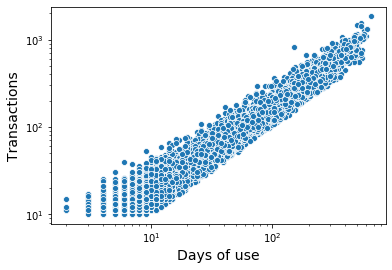

In [9]:
sns.scatterplot(x = 'days_of_use', y = 'transactions', data = results.sample(10000))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Days of use', fontsize = 14)
plt.ylabel('Transactions', fontsize = 14)

Let's plot the resulting data

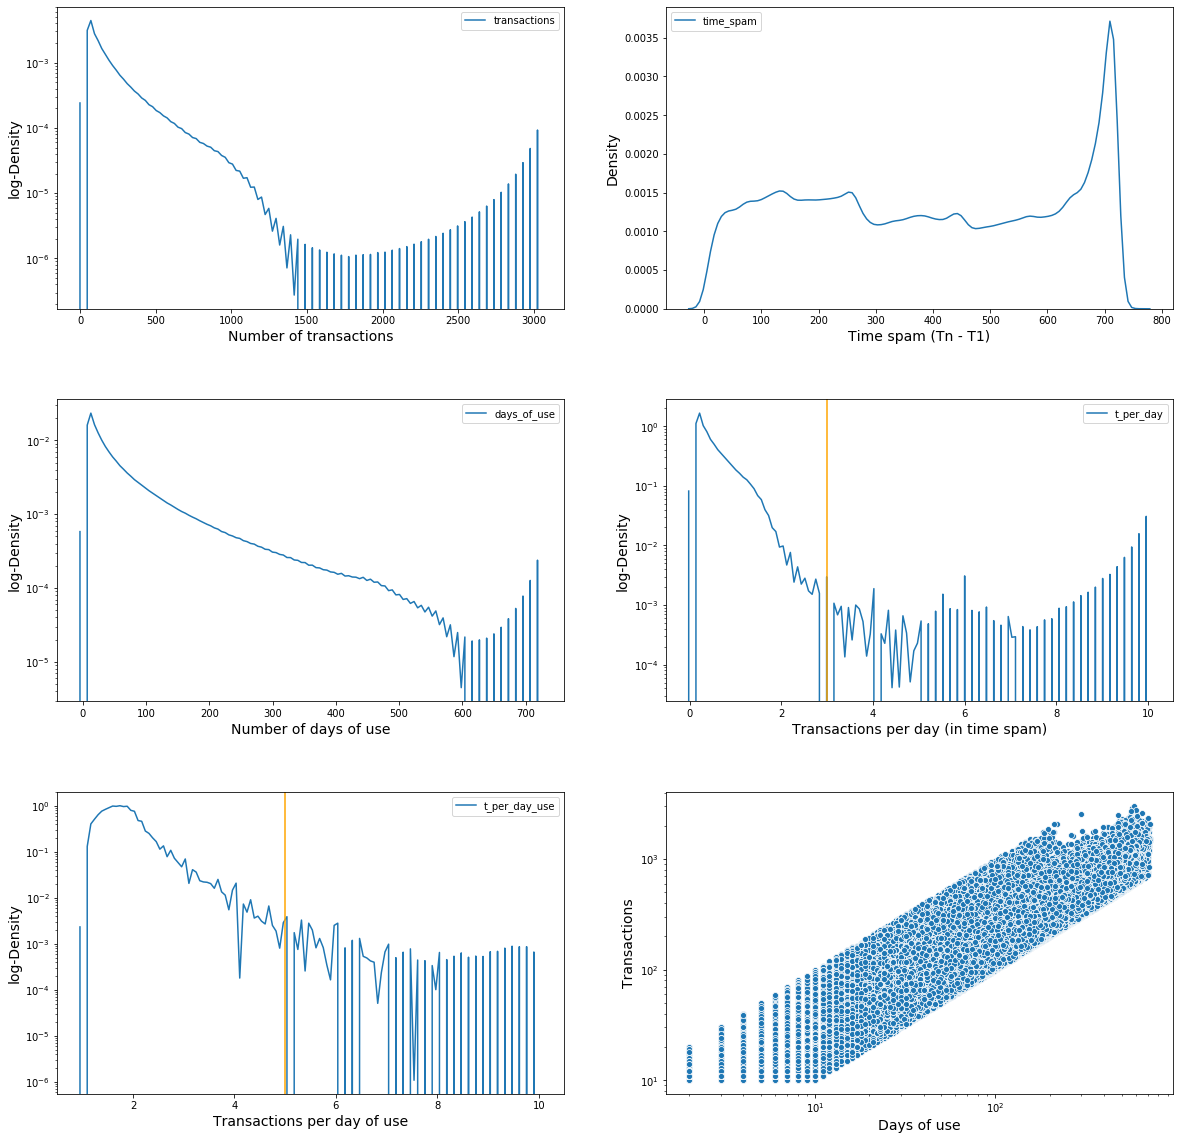

In [99]:
plot_distributions(results, True)

Last plot seems promessing. I will plot a density plot to understand where most of the obsertaions lie. 

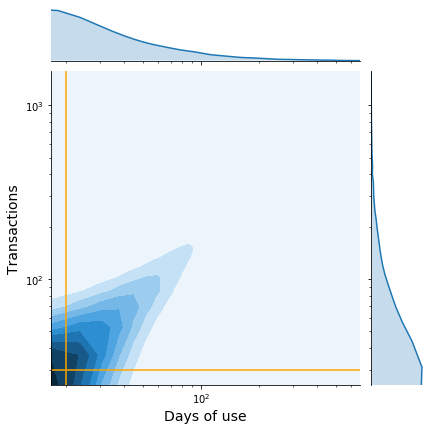

In [17]:
g = sns.jointplot(x = 'days_of_use', y = 'transactions', data = results.sample(10000),
                   kind = 'kde')
g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')
g.ax_joint.set_xlabel('Days of use', fontsize = 14)
g.ax_joint.set_ylabel('Transactions', fontsize = 14)
g.ax_joint.axvline(x=20, color = 'orange')
g.ax_joint.axhline(y=30, color = 'orange');

As we can see in this plot, there is a great concentration of users with low number of transactions and days of use, which are not ideal for the analysis. 

Base on this results, it seems that the ideal filters are the following: 

- Number of transactions per day less than 3. 
- Number of transactions per day of use  less than 5
- Days of use should be more than 20 
- Number of total transactions shoudl be more than 30 

These tresholds are marked in orange lines in the plot above. 

## Applying the filters

In [20]:
mask_1 = (results.days_of_use > 20) & (results.transactions > 30)
results_final = results[mask_1]
results_final = results_final[results_final.t_per_day_use <= 5]
results_final = results_final[results_final.t_per_day <= 3]

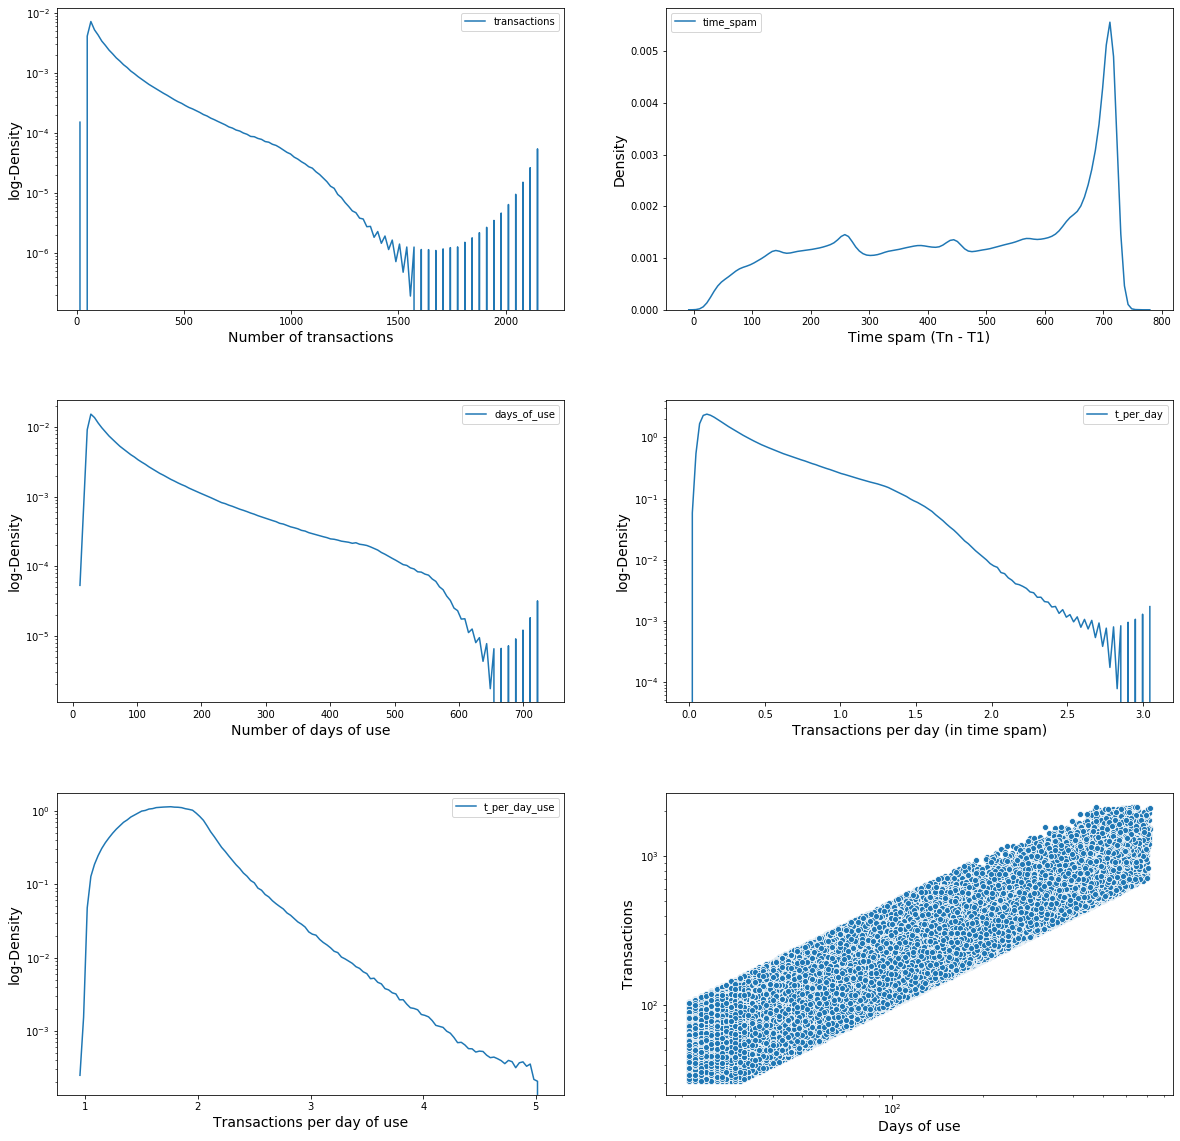

In [130]:
plot_distributions(results_final, False)

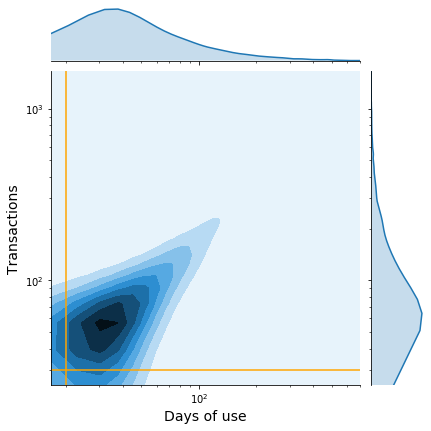

In [131]:
g = sns.jointplot(x = 'days_of_use', y = 'transactions', data = results_final.sample(10000),
                   kind = 'kde')
g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')
g.ax_joint.set_xlabel('Days of use', fontsize = 14)
g.ax_joint.set_ylabel('Transactions', fontsize = 14)
g.ax_joint.axvline(x=20, color = 'orange')
g.ax_joint.axhline(y=30, color = 'orange');

After the filters, the distributions tails seems to be more smooth and less irregular. 
The density plot of Days of use and Transactions shows a much better spreed of the data, suggesting he have successfully remove users with low observations. A bad cut-off point would result in average values similar to the cutt-off limits. However, it seems that the average days of use is located at about 40, and transactions at 60. Considering 40 days of use as woorking days, there's at least 2 months of observation in average for each user (assuming each week has 5 working days). 

In [25]:
dat = pd.read_csv('/Users/juandavidcaicedocastro/Documents/BERKELEY/17_PhD/02_Data/03_Transmilenio/02_255 project/data/id_frequency.csv')
initial_users = dat.shape[0]/1000000
final_users = results_final.shape[0]/1000000
pct_users = final_users*100/initial_users
total_transactions = dat['count'].sum()/1000000000
final_transactions = results_final.transactions.sum()/1000000000
pct_transactions = final_transactions*100/total_transactions

print (f'''Number of unique IDs: %.2f millions, 
Final number of unique IDs: %.2f millions, 
That is %.2f%% of the total users,

Total number of transactions: %.2f billions, 
Transactions by final users: %.2f billions, 
Percentage of transactions made by final users: %.2f%% ''' % (initial_users, 
                                                             final_users, 
                                                             pct_users,
                                                            total_transactions,
                                                             final_transactions,
                                                             pct_transactions
                                                            ))

Number of unique IDs: 15.36 millions, 
Final number of unique IDs: 6.69 millions, 
That is 43.56% of the total users,

Total number of transactions: 1.34 billions, 
Transactions by final users: 1.22 billions, 
Percentage of transactions made by final users: 90.94% 


Although we have eliminated about 60% of unique users, we still remain with more than 90% of the total transactions in the system over the 2 years of data

In [135]:
#Store remaining IDs for future use
results_final.idnumerotarjeta.to_csv(path_results + 'final_ids.csv', index = False)